In [50]:
import uuid
from pathlib import Path

import pandas_profiling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neptune.new as neptune
import seaborn as sns
import sklearn.ensemble
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import xgboost as xgb
from IPython.display import display

In [5]:
run_id = uuid.uuid4()

In [ ]:
# Include source files.
# source_files=["model.py", "prep_data.py"]

In [9]:
os.environ['NEPTUNE_API_TOKEN'], os.environ['NEPTUNE_PROJECT']

('eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3MmVkOTJkMC03ZmYyLTQ4ZjQtYmFmYy1hMmQzMjcxYWU5MjAifQ==',
 'proinsias/kaggle-tab202104')

In [10]:
run = neptune.init(
    name=f'run_{run_id}',
    # source_files=source_files,
)

Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/proinsias/kaggle-tab202104/e/TAB202104-1


In [13]:
# https://numpy.org/doc/stable/reference/generated/numpy.set_printoptions.html
np.set_printoptions(suppress=True)  # Print floating point numbers using fixed point notation.
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
# Print out the full DataFrame repr for wide DataFrames across multiple lines.
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.max_columns', 500)  # Set to None for unlimited number of output rows.  
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_rows', 500)  # Set to None for unlimited number of output rows.
pd.set_option('display.width', 120)  # Width of the display in characters.

In [12]:
input_path = Path('../data')

# Read in the data files

In [110]:
train = pd.read_csv(input_path / 'train.csv.gz', index_col='PassengerId')
print(train.shape)
display(train.head())

(100000, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [111]:
test = pd.read_csv(input_path / 'test.csv.gz', index_col='PassengerId')
print(test.shape)
display(test.head())

(100000, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


In [91]:
submission = pd.read_csv(input_path / 'sample_submission.csv.gz', index_col='PassengerId')
display(submission.head())

,Survived
PassengerId,
100000,1
100001,1
100002,1
100003,1
100004,1


# Balance of target

In [20]:
train['Survived'].value_counts(normalize=True)
# Pretty balanced.

0    0.57226
1    0.42774
Name: Survived, dtype: float64

# EDA

In [22]:
# profile = pandas_profiling.ProfileReport(train, explorative=True)
# profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## EDA of Base Continuous Variables

In [36]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [37]:
cont_vars = [
    'Pclass',
    'Age',
    'SibSp',
    'Parch',
    'Fare',
]

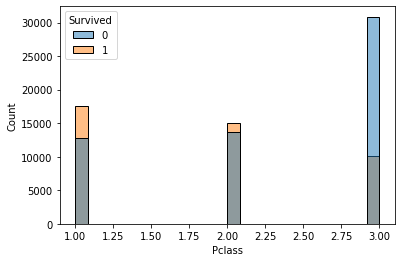

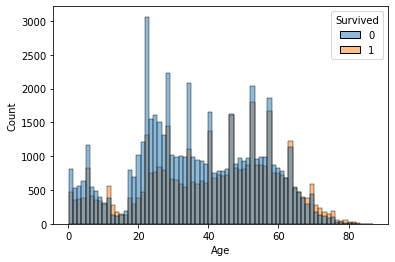

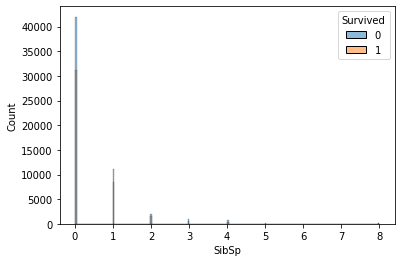

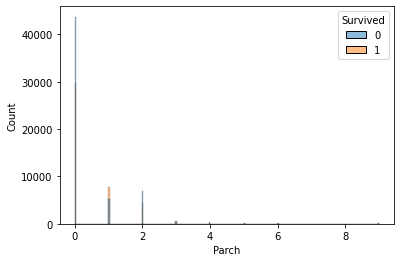

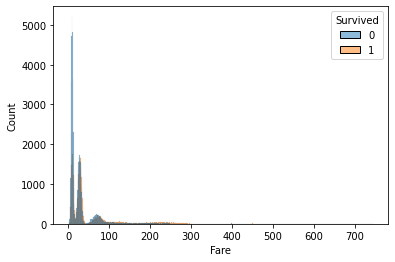

In [38]:
for cont_var in cont_vars:
    sns.histplot(
        x=cont_var,
        data=train,
        hue='Survived',
    );
    plt.show();

/Users/ftod/.pyenv/versions/tab202104/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


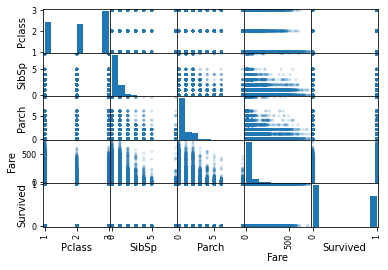

In [28]:
pd.plotting.scatter_matrix(train[cont_vars + ['Survived']], alpha=0.2);

In [29]:
corrDf = train[cont_vars + ['Survived']].corr().abs()
for col in corrDf.columns:
    corrDf.loc[col, col] = 0
idxmax = corrDf.idxmax(axis='columns')
max_ = corrDf.max(axis='columns')
(
    pd.DataFrame(
        index=corrDf.index,
        data={
            'idxmax': idxmax,
            'max': max_,
        },
    )
    .sort_values(
        by=[
            'max',
        ],
        ascending=False,
    )
)

,idxmax,max
Pclass,Fare,0.417354
Fare,Pclass,0.417354
Survived,Pclass,0.289723
SibSp,Parch,0.213126
Parch,SibSp,0.213126


## EDA of Categorical Variables

In [32]:
cat_vars = [
    'Sex',
    'Embarked',
]

In [33]:
for cat_var in cat_vars:
    train[cat_var] = train[cat_var].astype('category')

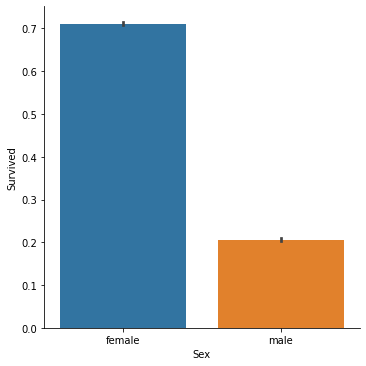

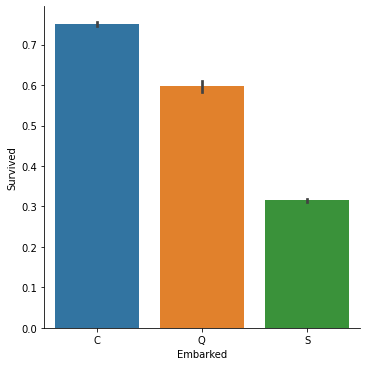

In [35]:
for cat_var in cat_vars:
    sns.catplot(x=cat_var, y='Survived', data=train, kind='bar',);
    plt.show();

# Transformations

In [149]:
def transform_vars(df, median_values):
    # Missing data

    for col in ['Age', 'Fare']:    
        mask = df[col].isnull()
        df.loc[mask, col] = median_values[col]

    # New variables
    
    mask = (df['Age'] >= 18)
    df['isAdult'] = mask.astype(int)
    
    mask = (df['SibSp'] > 0)
    df['hasSibSp'] = mask.astype(int)

    mask = (df['Parch'] > 0)
    df['hasParch'] = mask.astype(int)

    mask = (df['Parch'] == 0)
    mask &= (df['Age'] < 18)
    df['hasNanny'] = mask.astype(int)
    
    mask = (df['Sex'] == 'female')
    df['isFemale'] = mask.astype(int)

    mask = df['Cabin'].isnull()
    df.loc[~mask, 'Cabin_Letter'] = df.loc[~mask, 'Cabin'].str.slice(0, 1)
    df.loc[mask, 'Cabin_Letter'] = 'U'
    df.loc[~mask, 'Cabin_Thous'] = (df.loc[df['Cabin'].notnull(), 'Cabin'].str.slice(1).astype(int) / 1000).astype(int)
    df.loc[mask, 'Cabin_Thous'] = -1
    df['Cabin_Thous'] = df['Cabin_Thous'].astype(int)
    
    df = (
        df
        .drop(
            columns=[
                'Name',
                'Sex',
                'Cabin',
                'Ticket',
            ],
        )
    )
    
    return df

In [135]:
train.shape, test.shape

((100000, 18), (100000, 17))

In [136]:
median_values = (
    pd.concat(
        [
            train,
            test,
        ]
    )
    [['Age', 'Fare']]
    .median()
)
median_values

Age     31.00
Fare    20.25
dtype: float64

In [151]:
train_trans = transform_vars(train, median_values)
test_trans = transform_vars(test, median_values)

In [152]:
train_trans.shape, test_trans.shape

((100000, 14), (100000, 13))

In [163]:
def encode_variables(df, enc):
    cols = ['Embarked', 'Cabin_Letter']
    
    df = (
        pd.concat(
            [
                df.drop(
                    columns=cols,
                ),
                pd.DataFrame(
                    data=enc.transform(df[cols]),
                    index=df.index,
                )
            ],
            axis='columns',
        )
    )
    
    return df

In [164]:
enc = sklearn.preprocessing.OneHotEncoder(sparse=False)
enc.fit(
    pd.concat(
        [
            train_trans[['Embarked', 'Cabin_Letter']],
            test_trans[['Embarked', 'Cabin_Letter']],
        ]
    )
)

OneHotEncoder(sparse=False)

In [187]:
train_enc = encode_variables(train_trans, enc)
test_enc = encode_variables(test_trans, enc)

In [188]:
train_enc.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,isAdult,hasSibSp,hasParch,hasNanny,isFemale,Cabin_Thous,0,1,2,3,4,5,6,7,8,9,10
PassengerId,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,31.00,2,0,27.14,1,1,0,0,0,12,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,3,31.00,0,0,13.35,1,0,0,0,0,-1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,3,0.33,1,2,71.29,0,1,1,0,0,-1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,3,19.00,0,0,13.04,1,0,0,0,0,-1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,3,25.00,0,0,7.76,1,0,0,0,0,-1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## EDA of new Variables

In [176]:
train_enc['isAdult'].value_counts(dropna=False)

1    88083
0    11917
Name: isAdult, dtype: int64

In [177]:
train_enc['hasSibSp'].value_counts(dropna=False)

0    73308
1    26692
Name: hasSibSp, dtype: int64

In [178]:
train_enc['hasParch'].value_counts(dropna=False)

0    73540
1    26460
Name: hasParch, dtype: int64

In [179]:
train_enc['hasNanny'].value_counts(dropna=False)

0    95664
1     4336
Name: hasNanny, dtype: int64

In [180]:
train_enc['isFemale'].value_counts(dropna=False)

0    56114
1    43886
Name: isFemale, dtype: int64

In [181]:
train_enc['Cabin_Thous'].value_counts(dropna=False)

-1     67866
 7      1705
 19     1705
 14     1705
 13     1681
 12     1677
 9      1674
 18     1663
 8      1654
 15     1644
 11     1632
 17     1607
 20     1594
 16     1594
 10     1571
 4      1563
 6      1553
 5      1553
 21     1160
 3      1128
 22      771
 2       729
 1       297
 23      274
Name: Cabin_Thous, dtype: int64

In [183]:
train_enc.columns[pd.isnull(train_enc).sum() > 0].values

array([], dtype=object)

# Train

## Pull out the target, and make a validation split

In [189]:
target = train_enc.pop('Survived')

In [185]:
train_enc.shape, train_enc.shape

((100000,), (100000,))

In [190]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(train_enc, target, test_size=0.25)

In [191]:
def getXgb():
    return xgb.XGBClassifier(
        n_jobs=-1,
        random_state=0,
        use_label_encoder=False,
    )

In [196]:
%%time
clf = getXgb()
clf.fit(X_train, y_train)

[15:33:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 23.1 s, sys: 380 ms, total: 23.5 s
Wall time: 2.13 s


In [200]:
y_proba = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)

In [201]:
score = sklearn.metrics.accuracy_score(y_test, y_pred)
print(f'{score:0.5f} v 0.77372 reference value')

0.77372 v 0.77372 reference value


## Let's take a look at how the model predicted the various classes

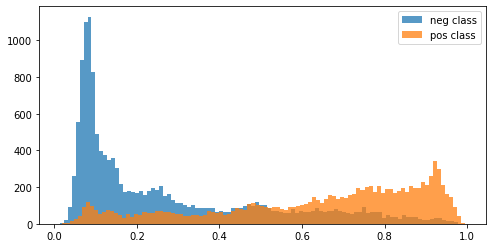

In [202]:
# The graph below shows that the model does well with most of the negative observations, but struggles with many of the positive observations.
plt.figure(figsize=(8,4))
plt.hist(y_proba[np.where(y_test == 0)], bins=100, alpha=0.75, label='neg class')
plt.hist(y_proba[np.where(y_test == 1)], bins=100, alpha=0.75, label='pos class')
plt.legend()
plt.show()

# Train it on all the data and create submission

In [204]:
%%time
clf = getXgb()
clf.fit(train_enc, target)
submission['Survived'] = clf.predict(test_enc)
filename = f'submission_{run_id}.csv'
submission.to_csv(input_path / filename)
filename

[15:37:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 30.9 s, sys: 500 ms, total: 31.4 s
Wall time: 2.8 s


'submission_40d4c6cd-f213-4fe4-96bf-21a21a67fe35.csv'

In [ ]:
# run["train/accuracy"].log(acc)
# run["train/loss"].log(loss)
# run['metric'].log(metric)
    
# # single value
# run['some/structure'] = val

# # for series of values
# for val in vals:
#     run['some/structure'].log(val)

In [ ]:
# run['parameters/activation'] = ACTIVATION

# PARAMS = {'epoch_nr': 5,
#           'batch_size': 32,
#           'dense': 512,
#           'optimizer': 'sgd',
#           'metrics': ['accuracy', 'binary_accuracy'],
#           'activation': 'relu'}
# run['parameters'] = PARAMS

In [ ]:
# # Log figure to run
# run['matplotlib-fig'].upload(fig)
# run['train/distribution'].log(plt_fig)

# # Log Matplotlib figure (matplotlib.figure.Figure) or plotly figure as an interactive chart,
# # by using neptune.types.File.as_html().
# # This option is tested with matplotlib==3.2.0 and plotly==4.12.0.
# # Make sure that you have correct versions installed. See: plotly installation guide.
# from neptune.new.types import File
# run['visuals/matplotlib-fig'] = File.as_html(fig)

In [ ]:
# # Log single String
# run['aux/text'] = 'text I keep track of, like query or tokenized word'

# # Log series of String to one log
# for epoch in range(epochs_nr):
#     token = str(...)
#     run['train/tokens'].log(token)

In [ ]:
# # Log file
# run['aux/data'].upload('auxiliary-data.zip')

# # Save multiple files under a path
# run["config_files"].upload_files([path_to_config_1, path_to_config_2])

# # You can also use wildcard patterns ("glob") with .upload_files()
# run["preprocessing_scripts"].upload_files("./preprocessing/*.py")